In [4]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.data.user_57668ee56fca2390e600024a import algothon_2
from quantopian.pipeline.factors import CustomFactor, AverageDollarVolume, RollingLinearRegressionOfReturns, DailyReturns, AnnualizedVolatility
from quantopian.pipeline.data.user_57668ee56fca2390e600024a import algothon_3

from scipy.stats.mstats import zscore, winsorize

import numpy as np
import pandas as pd
from sklearn.svm import SVR

def util_winsor5(x):
    return (winsorize(x,limits=[0.05, 0.05]))

def beta_fitconvert(a):
    z = a/np.nanmax(a)
    z = z-np.nanmin(z)
    return(z)

def nanzscore(a):
    z = a                    # initialise array for zscores
    z[~np.isnan(a)] = util_winsor5(z[~np.isnan(z)])
    z[~np.isnan(a)] = zscore(z[~np.isnan(z)])    
    return(z)

class Volatility(CustomFactor):
    
    inputs = [AnnualizedVolatility()]
    window_length = 1
    
    def compute(self, today, assets, out, AnnualizedVolatility):  
        out[:] =  ((AnnualizedVolatility))

pipe = Pipeline(
    columns={
        's_all': algothon_2.s_all.latest,
        's_none': algothon_2.s_non.latest,
        's_risk': algothon_2.s_risk.latest,
        's_momentum': algothon_2.s_mom.latest,
        's_sc': algothon_2.s_sc.latest,
        'vol' : Volatility(),
        'nn_all': algothon_3.nn_all.latest
    },
    screen=algothon_3.nn_all.latest.notnull()
)
df = run_pipeline(pipe, '2019-01-02', '2019-10-18')
df.head()


nn_all  s_all  s_momentum  \
2019-01-02 00:00:00+00:00 Equity(2 [ARNC])      1.0    NaN         NaN   
                          Equity(24 [AAPL])    -1.0    NaN         NaN   
                          Equity(52 [ABM])      1.0    NaN         NaN   
                          Equity(62 [ABT])      1.0    NaN         NaN   
                          Equity(64 [GOLD])     1.0    NaN         NaN   

                                             s_none  s_risk  s_sc       vol  
2019-01-02 00:00:00+00:00 Equity(2 [ARNC])      NaN     NaN   NaN  0.401462  
                          Equity(24 [AAPL])     NaN     NaN   NaN  0.287593  
                          Equity(52 [ABM])      NaN     NaN   NaN  0.344949  
                          Equity(62 [ABT])      NaN     NaN   NaN  0.223316  
                          Equity(64 [GOLD])     NaN     NaN   NaN  0.317482

(73211, 1)

In [6]:
df['custom_all'] = df['nn_all']/(df['vol']*100) 
df = df.dropna(subset=['custom_all'])
df = df[df>-np.inf]
df = df[df<np.inf]

In [7]:
df.head()

nn_all  s_all  s_momentum  \
2019-01-02 00:00:00+00:00 Equity(2 [ARNC])      1.0    NaN         NaN   
                          Equity(24 [AAPL])    -1.0    NaN         NaN   
                          Equity(52 [ABM])      1.0    NaN         NaN   
                          Equity(62 [ABT])      1.0    NaN         NaN   
                          Equity(64 [GOLD])     1.0    NaN         NaN   

                                             s_none  s_risk  s_sc       vol  \
2019-01-02 00:00:00+00:00 Equity(2 [ARNC])      NaN     NaN   NaN  0.401462   
                          Equity(24 [AAPL])     NaN     NaN   NaN  0.287593   
                          Equity(52 [ABM])      NaN     NaN   NaN  0.344949   
                          Equity(62 [ABT])      NaN     NaN   NaN  0.223316   
                          Equity(64 [GOLD])     NaN     NaN   NaN  0.317482   

                                             custom_all  
2019-01-02 00:00:00+00:00 Equity(2 [ARNC])     0.024909  
                          Equity(24 [AAPL])   -0.034771  
                          Equity(52 [ABM])     0.028990  
                          Equity(62 [ABT])     0.044780  
                          Equity(64 [GOLD])    0.031498

Dropped 10.2% entries from factor data: 10.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.067859  0.021989  0.005507  0.021897  92185  33.352991
2                0.020725  0.034253  0.027105  0.003389  92076  33.313555
3                0.032468  5.424948  0.059477  0.214621  92131  33.333454

Returns Analysis


1D     5D    20D
Ann. alpha                                     0.048  0.064  0.066
beta                                          -0.410 -0.439 -0.436
Mean Period Wise Return Top Quantile (bps)     1.094  2.396  3.681
Mean Period Wise Return Bottom Quantile (bps)  0.315 -1.422 -3.332
Mean Period Wise Spread (bps)                  0.779  3.806  6.998

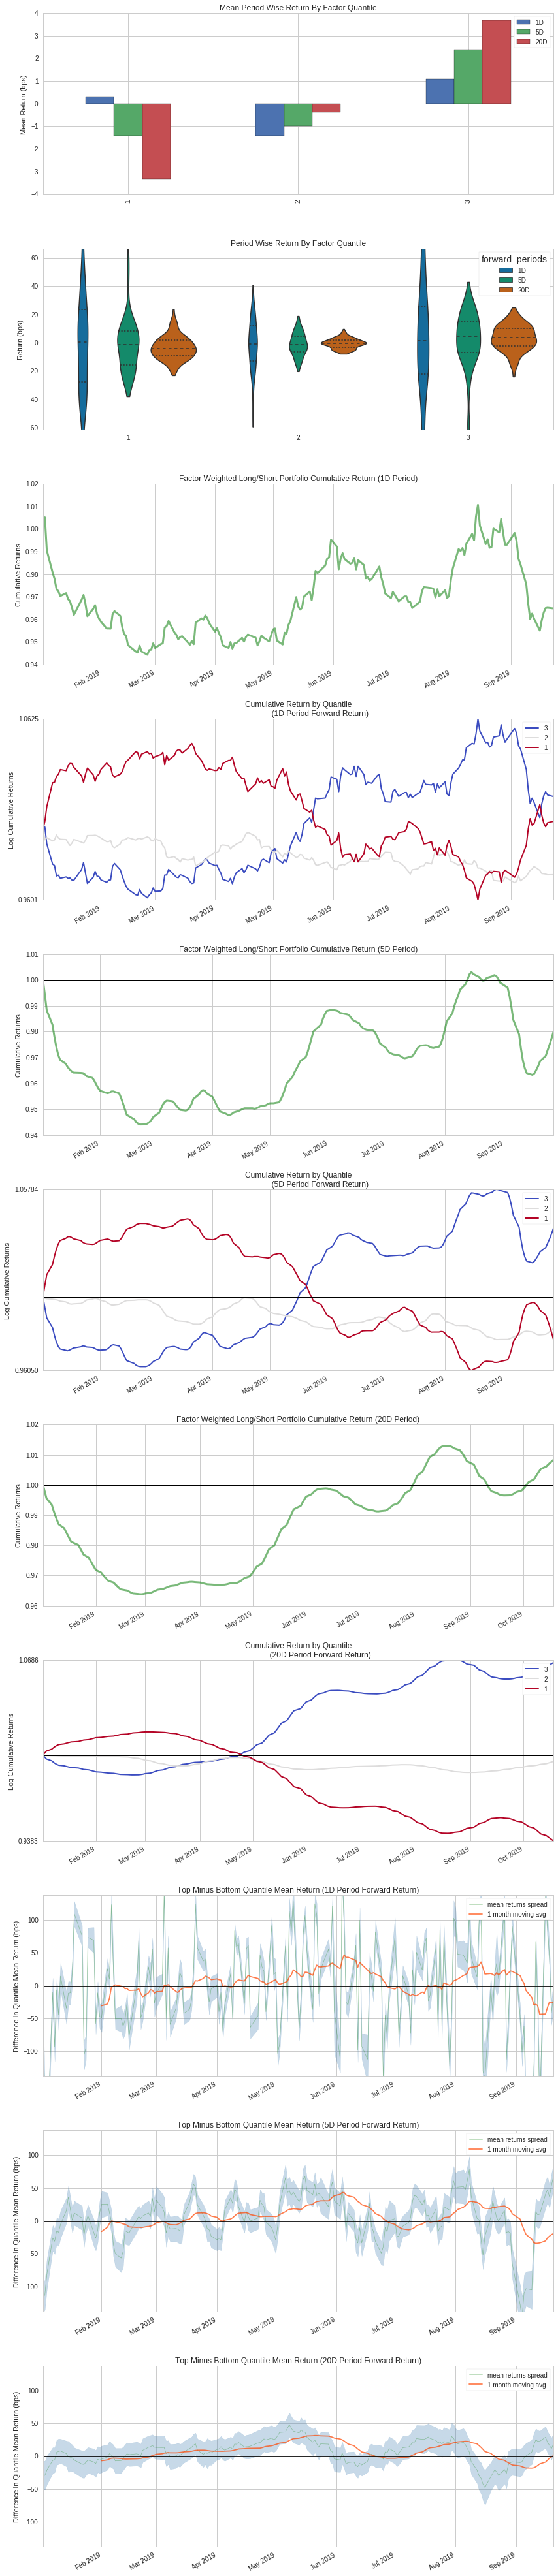

Information Analysis


1D     5D    20D
IC Mean           0.024  0.050  0.086
IC Std.           0.127  0.128  0.123
Risk-Adjusted IC  0.192  0.394  0.697
t-stat(IC)        2.595  5.312  9.401
p-value(IC)       0.010  0.000  0.000
IC Skew          -0.017 -0.483 -0.243
IC Kurtosis      -0.773 -0.279 -0.489

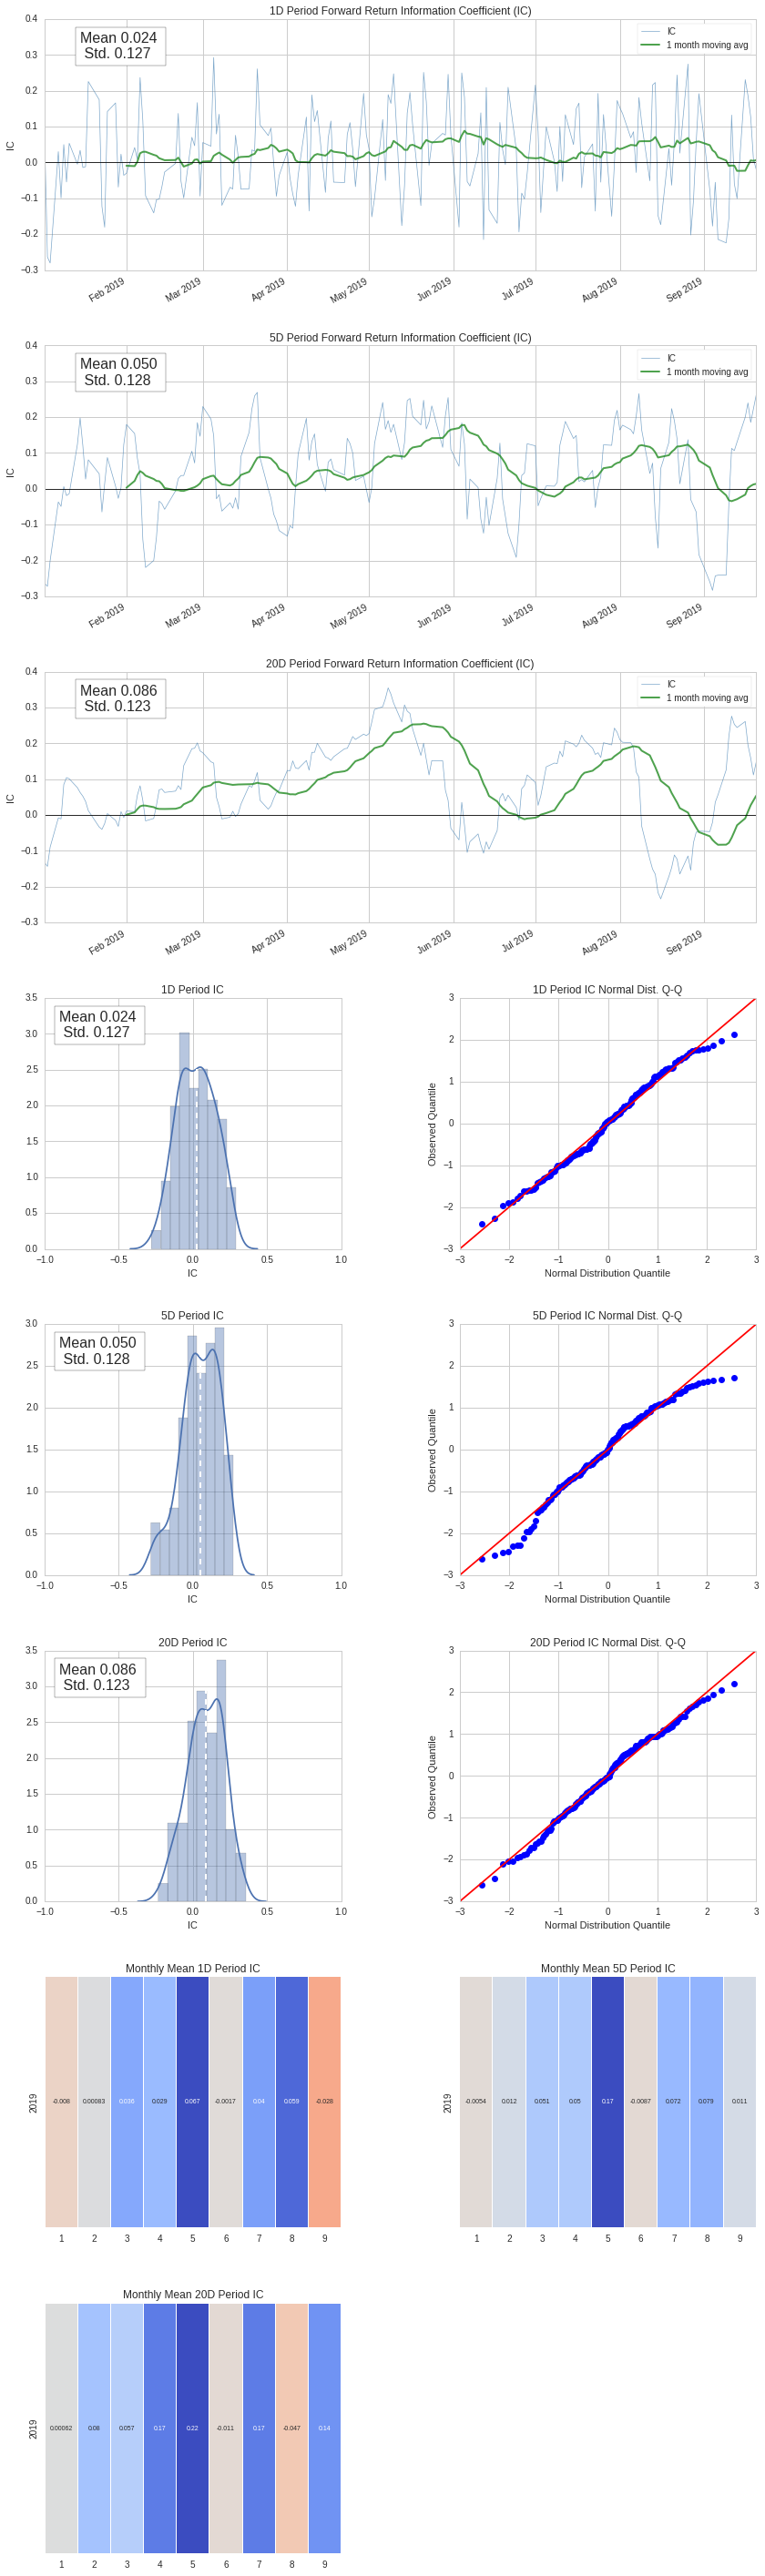

Turnover Analysis


1D    20D     5D
Quantile 1 Mean Turnover   0.007  0.036  0.019
Quantile 2 Mean Turnover   0.009  0.056  0.023
Quantile 3 Mean Turnover   0.006  0.031  0.017

1D     5D    20D
Mean Factor Rank Autocorrelation  0.993  0.981  0.983

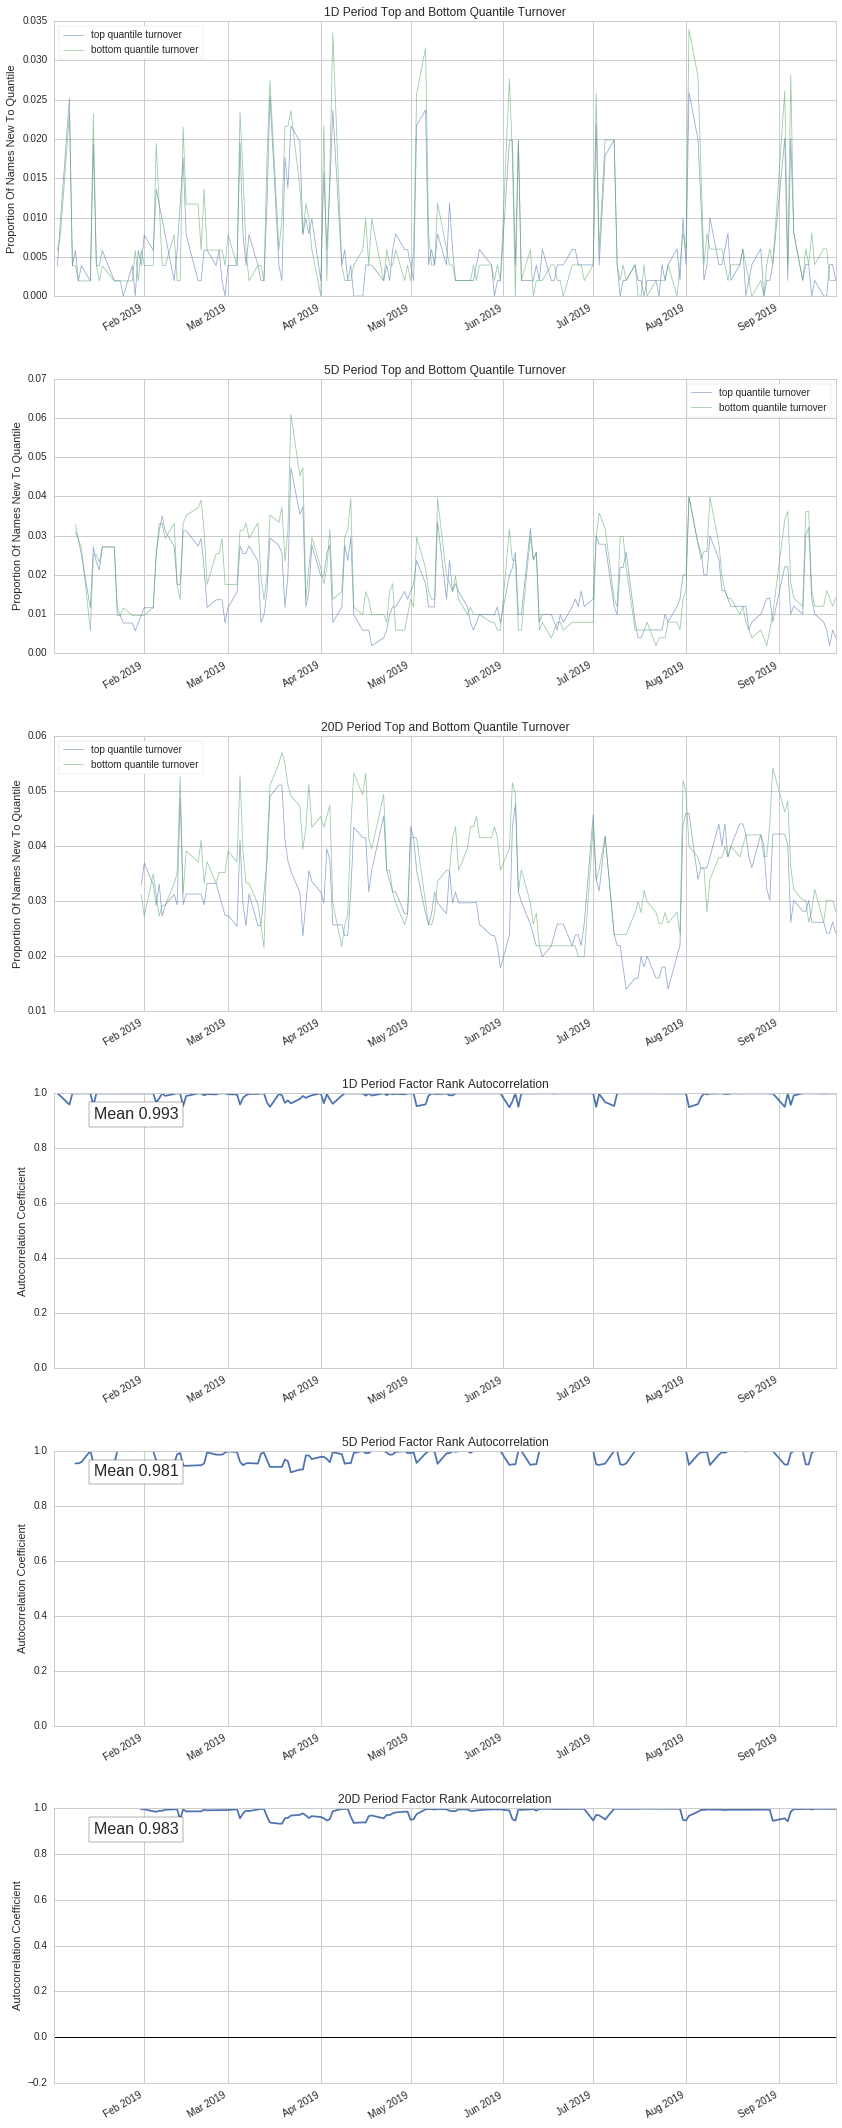

In [8]:

# Import prices function
from quantopian.research import prices

# Get list of unique assets from the pipeline output
asset_list = df.index.levels[1].unique()

# Query pricing data for all assets present during
# evaluation period
asset_prices = prices(
    asset_list,
    start='2019-01-02',
    end='2019-10-18'
)


# Import Alphalens
import alphalens as al

# Get asset forward returns and quantile classification
# based on sentiment scores
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=df['custom_all'],
    prices=asset_prices,
    quantiles=3,
    periods=(1,5,20)
)

al.tears.create_full_tear_sheet(factor_data)


In [9]:
df['custom_xnone'] = df['s_none']/(df['vol']*100) 
df = df.dropna()
df = df[df>-np.inf]

Dropped 10.5% entries from factor data: 10.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.049659  0.016697 -0.019923  0.008550  21835  33.413929
2               -0.023938  0.029781  0.016293  0.014883  21731  33.254778
3               -0.012853  0.070322  0.038511  0.008542  21781  33.331293

Returns Analysis


1D     5D    20D
Ann. alpha                                     0.100  0.136  0.131
beta                                          -0.172 -0.206 -0.241
Mean Period Wise Return Top Quantile (bps)     1.103  2.860  4.319
Mean Period Wise Return Bottom Quantile (bps) -5.816 -6.850 -4.949
Mean Period Wise Spread (bps)                  6.920  9.653  9.226

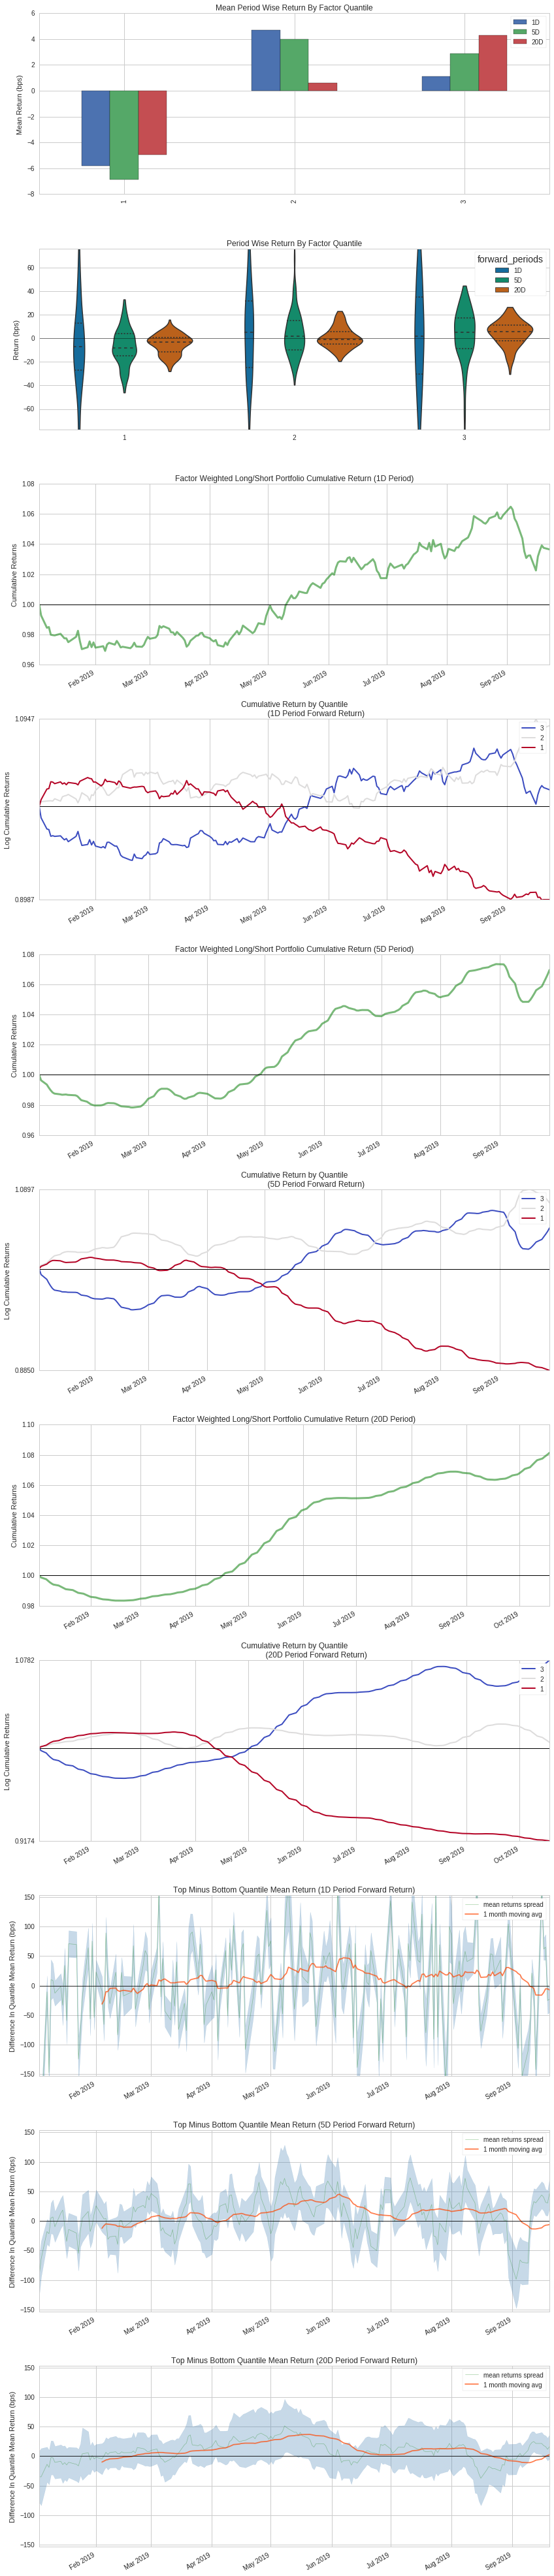

Information Analysis


1D     5D    20D
IC Mean           0.026  0.053  0.087
IC Std.           0.137  0.130  0.121
Risk-Adjusted IC  0.187  0.404  0.720
t-stat(IC)        2.514  5.436  9.693
p-value(IC)       0.013  0.000  0.000
IC Skew          -0.112 -0.418 -0.149
IC Kurtosis      -0.564 -0.379 -0.709

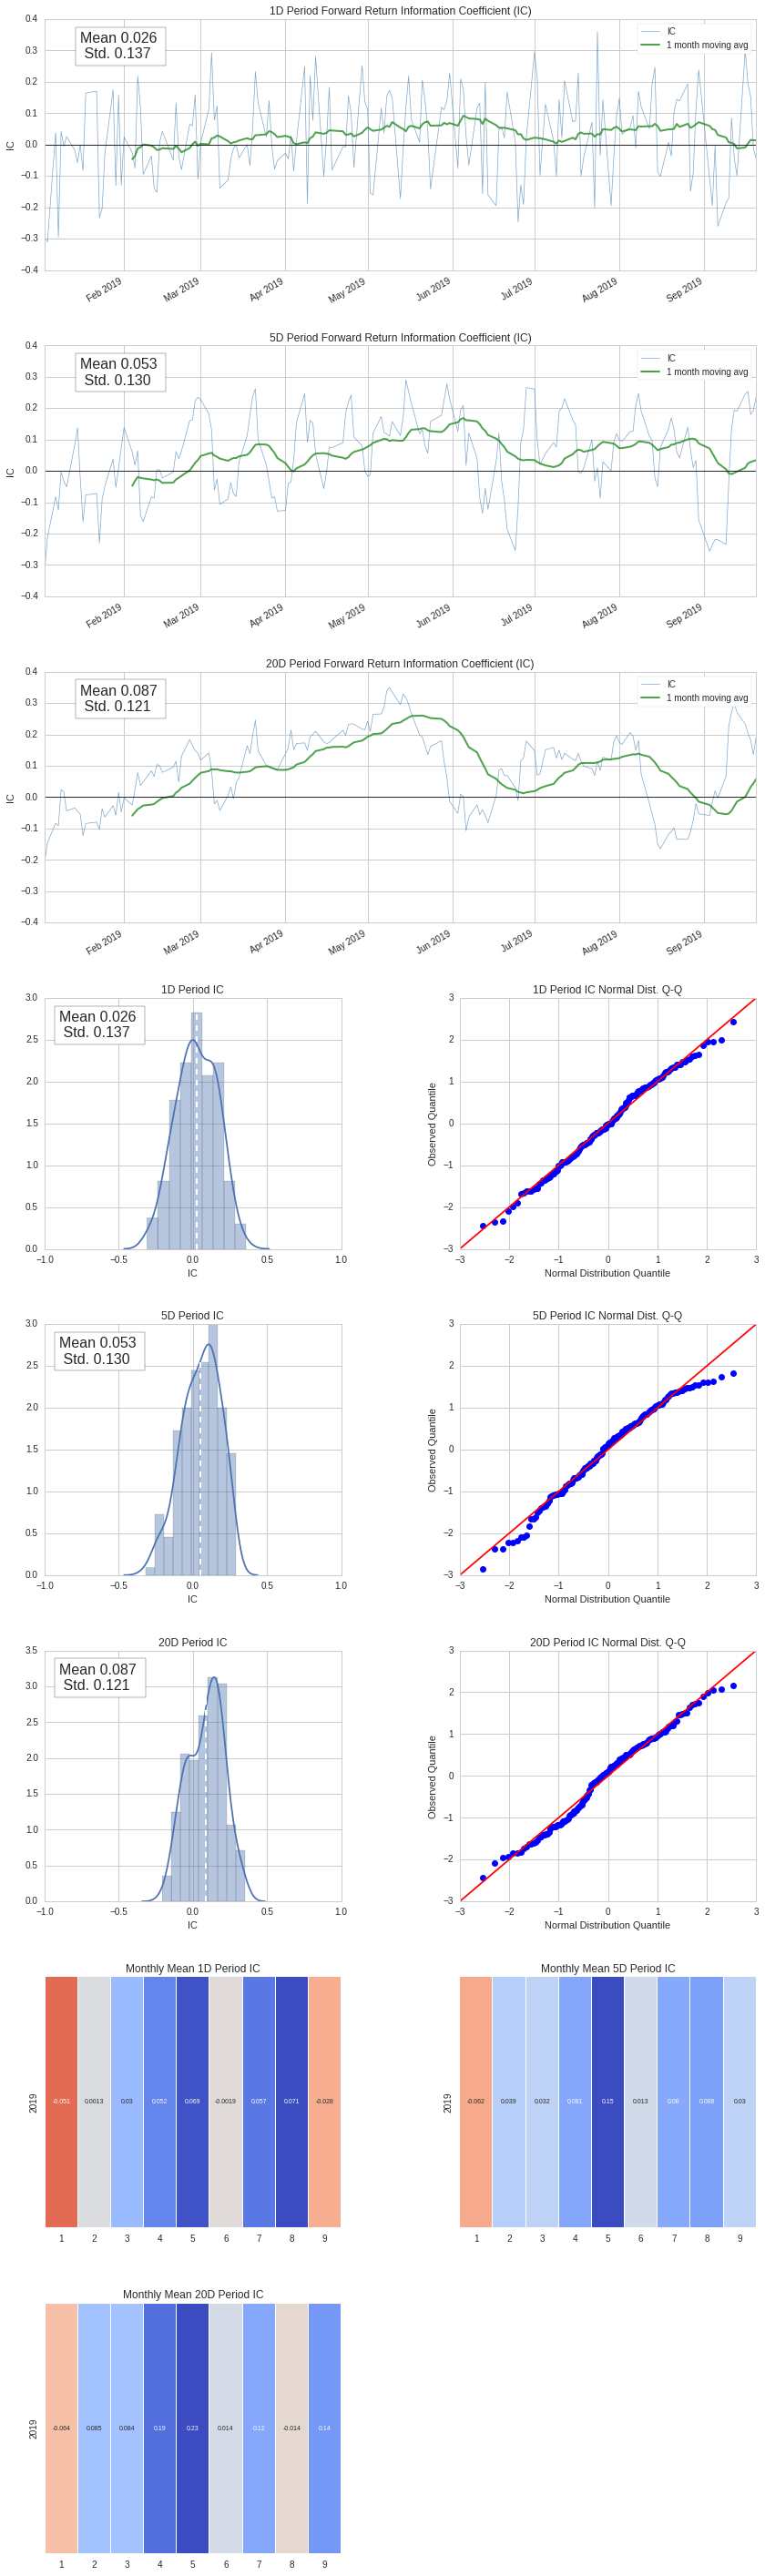

Turnover Analysis


1D    20D     5D
Quantile 1 Mean Turnover   0.085  0.386  0.193
Quantile 2 Mean Turnover   0.082  0.368  0.184
Quantile 3 Mean Turnover   0.025  0.093  0.056

1D     5D    20D
Mean Factor Rank Autocorrelation  0.942  0.859  0.729

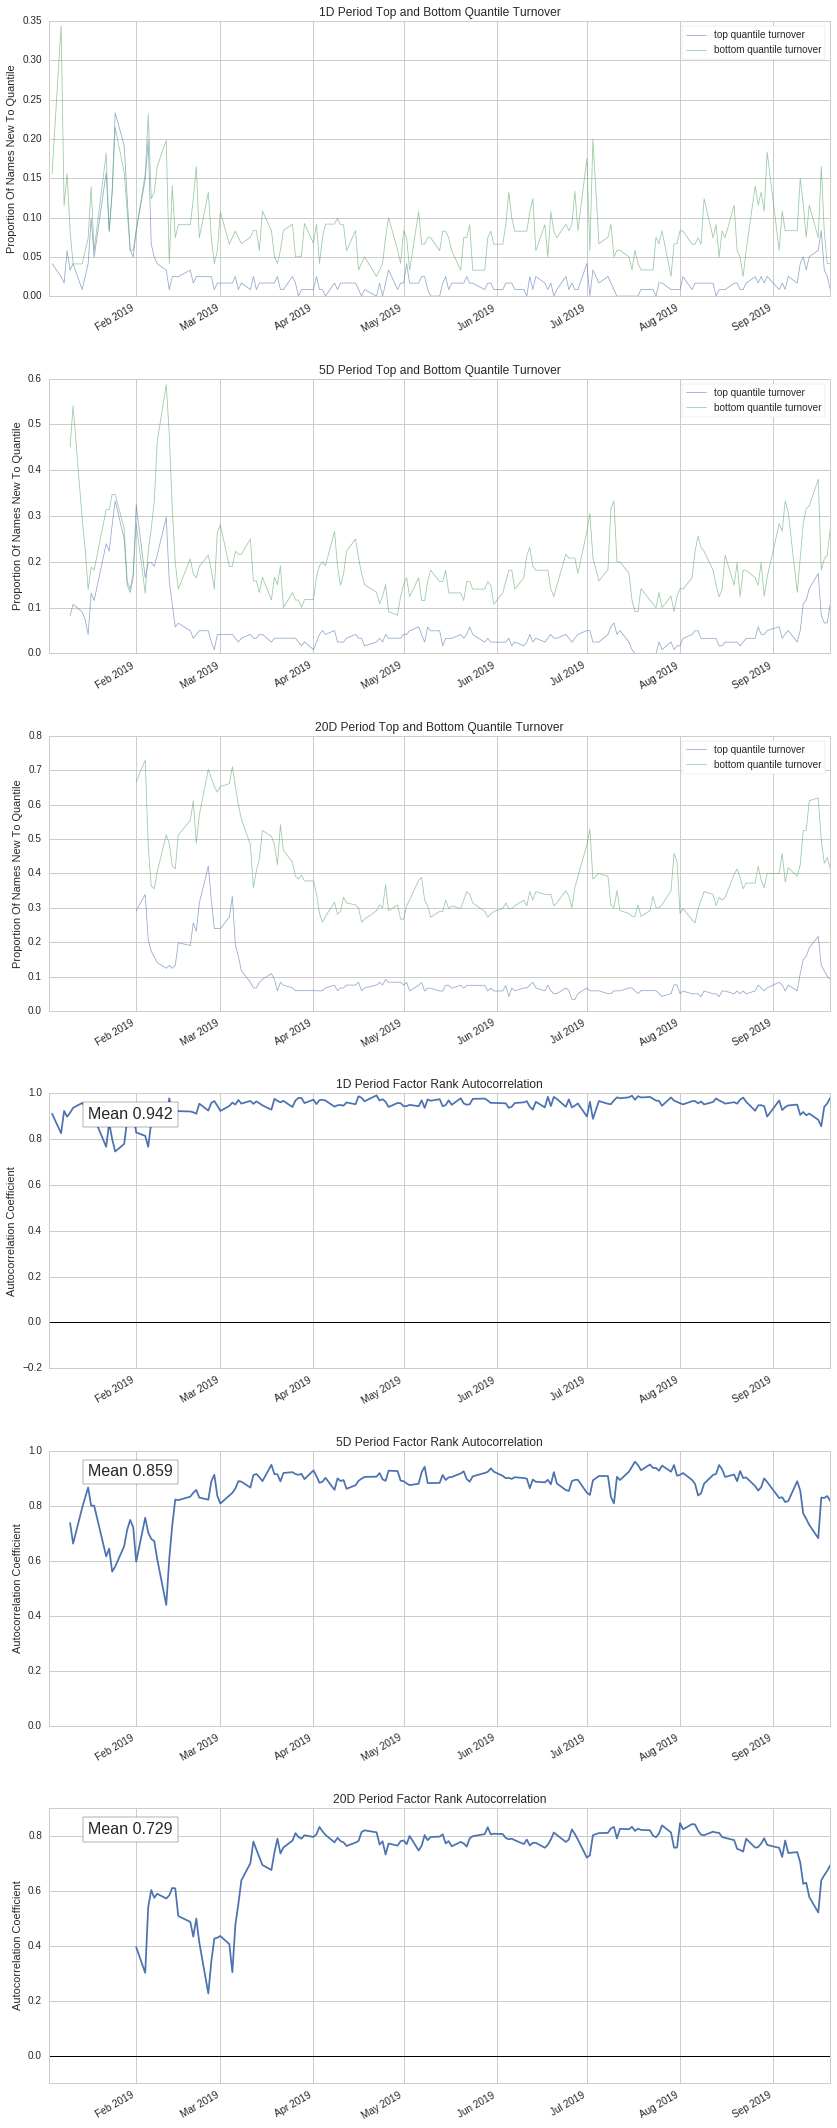

In [10]:

# Import prices function
from quantopian.research import prices

# Get list of unique assets from the pipeline output
asset_list = df.index.levels[1].unique()

# Query pricing data for all assets present during
# evaluation period
asset_prices = prices(
    asset_list,
    start='2019-01-02',
    end='2019-10-18'
)


# Import Alphalens
import alphalens as al

# Get asset forward returns and quantile classification
# based on sentiment scores
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=df['custom_xnone'],
    prices=asset_prices,
    quantiles=3,
    periods=(1,5,20)
)

al.tears.create_full_tear_sheet(factor_data)


Dropped 10.5% entries from factor data: 10.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.058744  0.012626 -0.021772  0.006835  21835  33.413929
2               -0.019766  0.029492  0.016599  0.013276  21731  33.254778
3                0.024538  0.070322  0.038369  0.008254  21781  33.331293

Returns Analysis


1D     5D    20D
Ann. alpha                                     0.068  0.087  0.094
beta                                          -0.144 -0.143 -0.139
Mean Period Wise Return Top Quantile (bps)     0.943  2.697  3.993
Mean Period Wise Return Bottom Quantile (bps) -1.164 -2.845 -3.676
Mean Period Wise Spread (bps)                  2.107  5.486  7.603

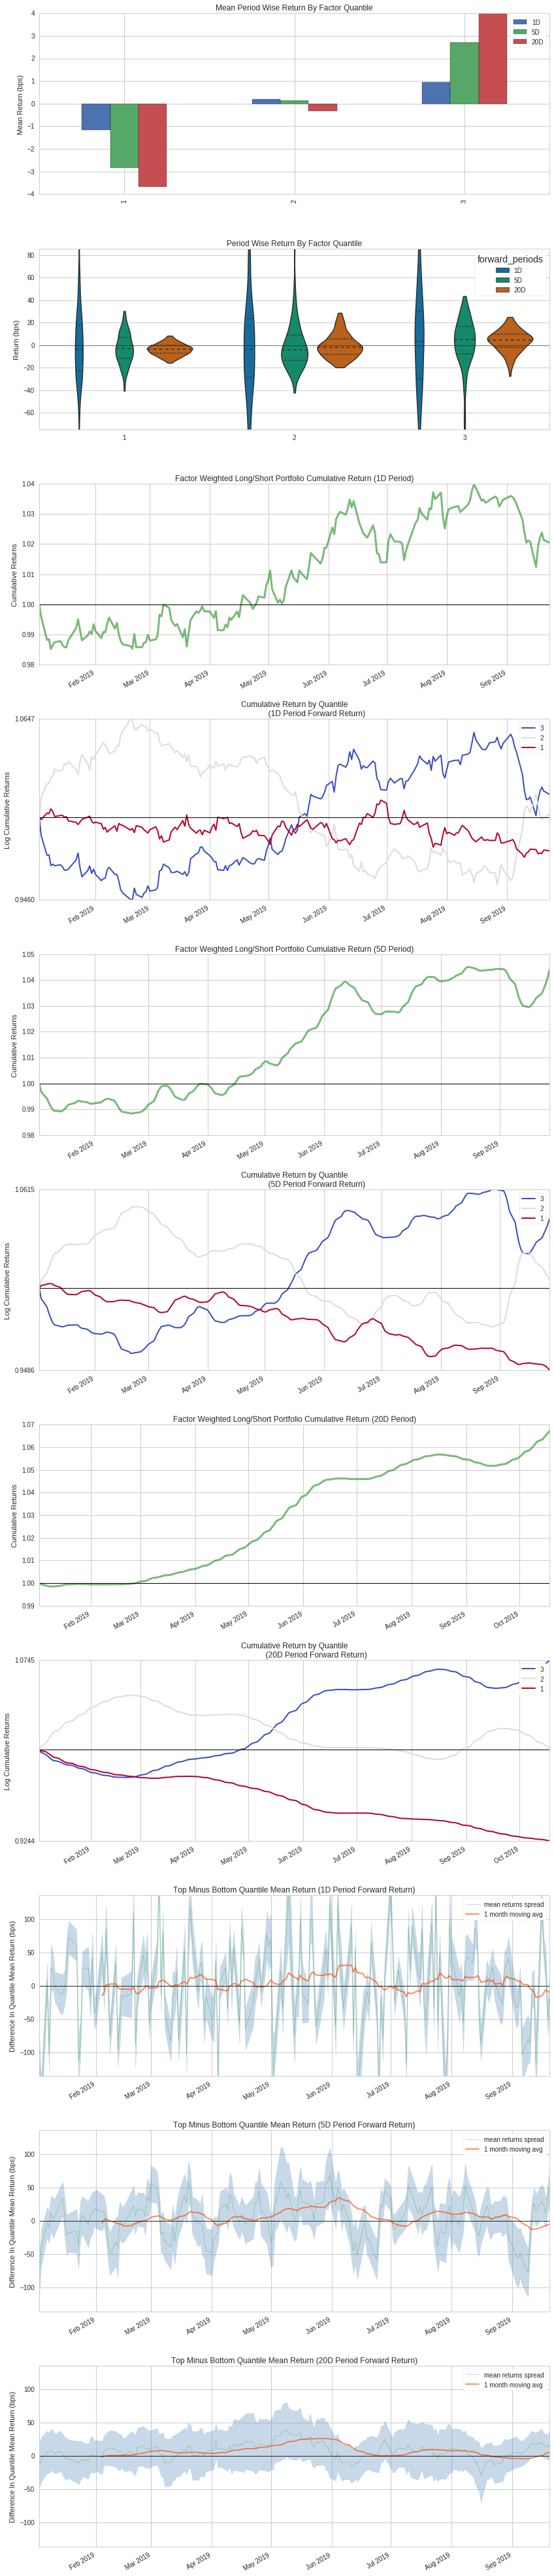

Information Analysis


1D     5D     20D
IC Mean           0.022  0.048   0.090
IC Std.           0.132  0.124   0.096
Risk-Adjusted IC  0.169  0.384   0.934
t-stat(IC)        2.276  5.164  12.560
p-value(IC)       0.024  0.000   0.000
IC Skew          -0.061 -0.222  -0.056
IC Kurtosis      -0.504 -0.429  -0.105

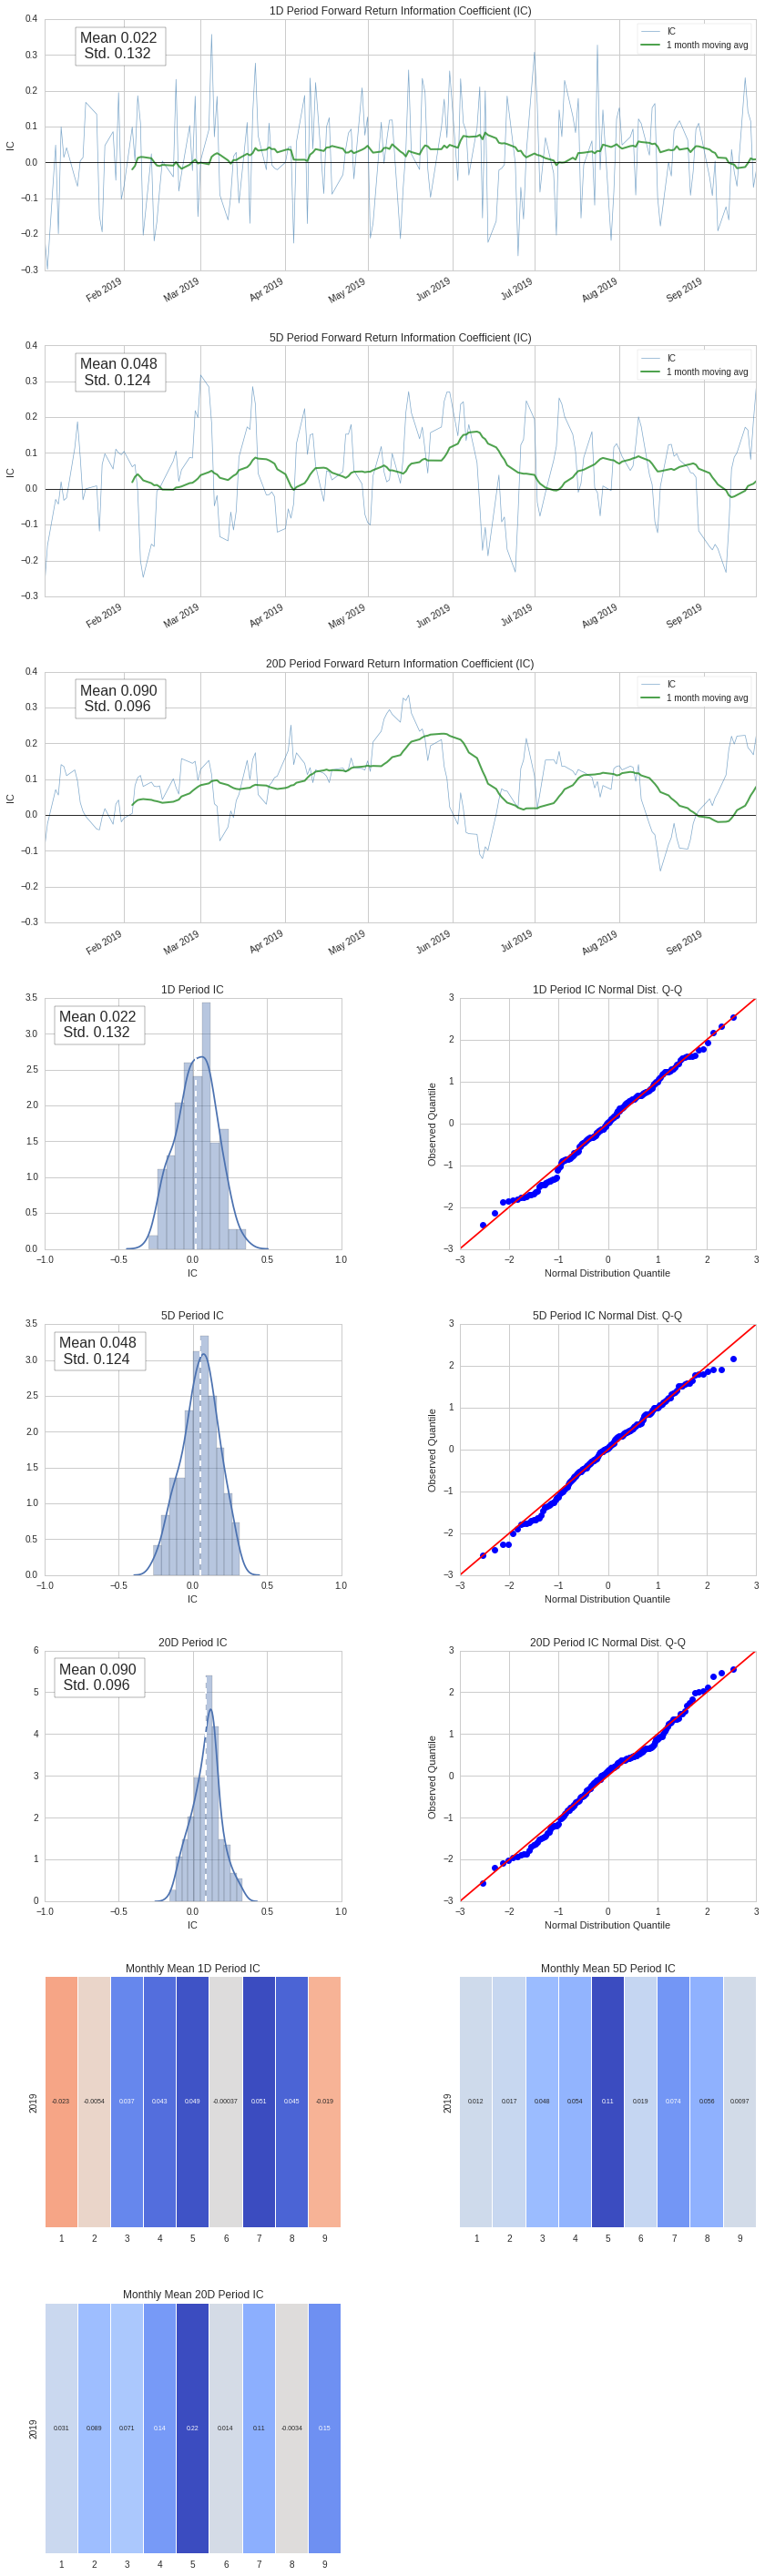

Turnover Analysis


1D    20D     5D
Quantile 1 Mean Turnover   0.048  0.240  0.117
Quantile 2 Mean Turnover   0.047  0.231  0.112
Quantile 3 Mean Turnover   0.017  0.081  0.040

1D    5D   20D
Mean Factor Rank Autocorrelation  0.964  0.91  0.81

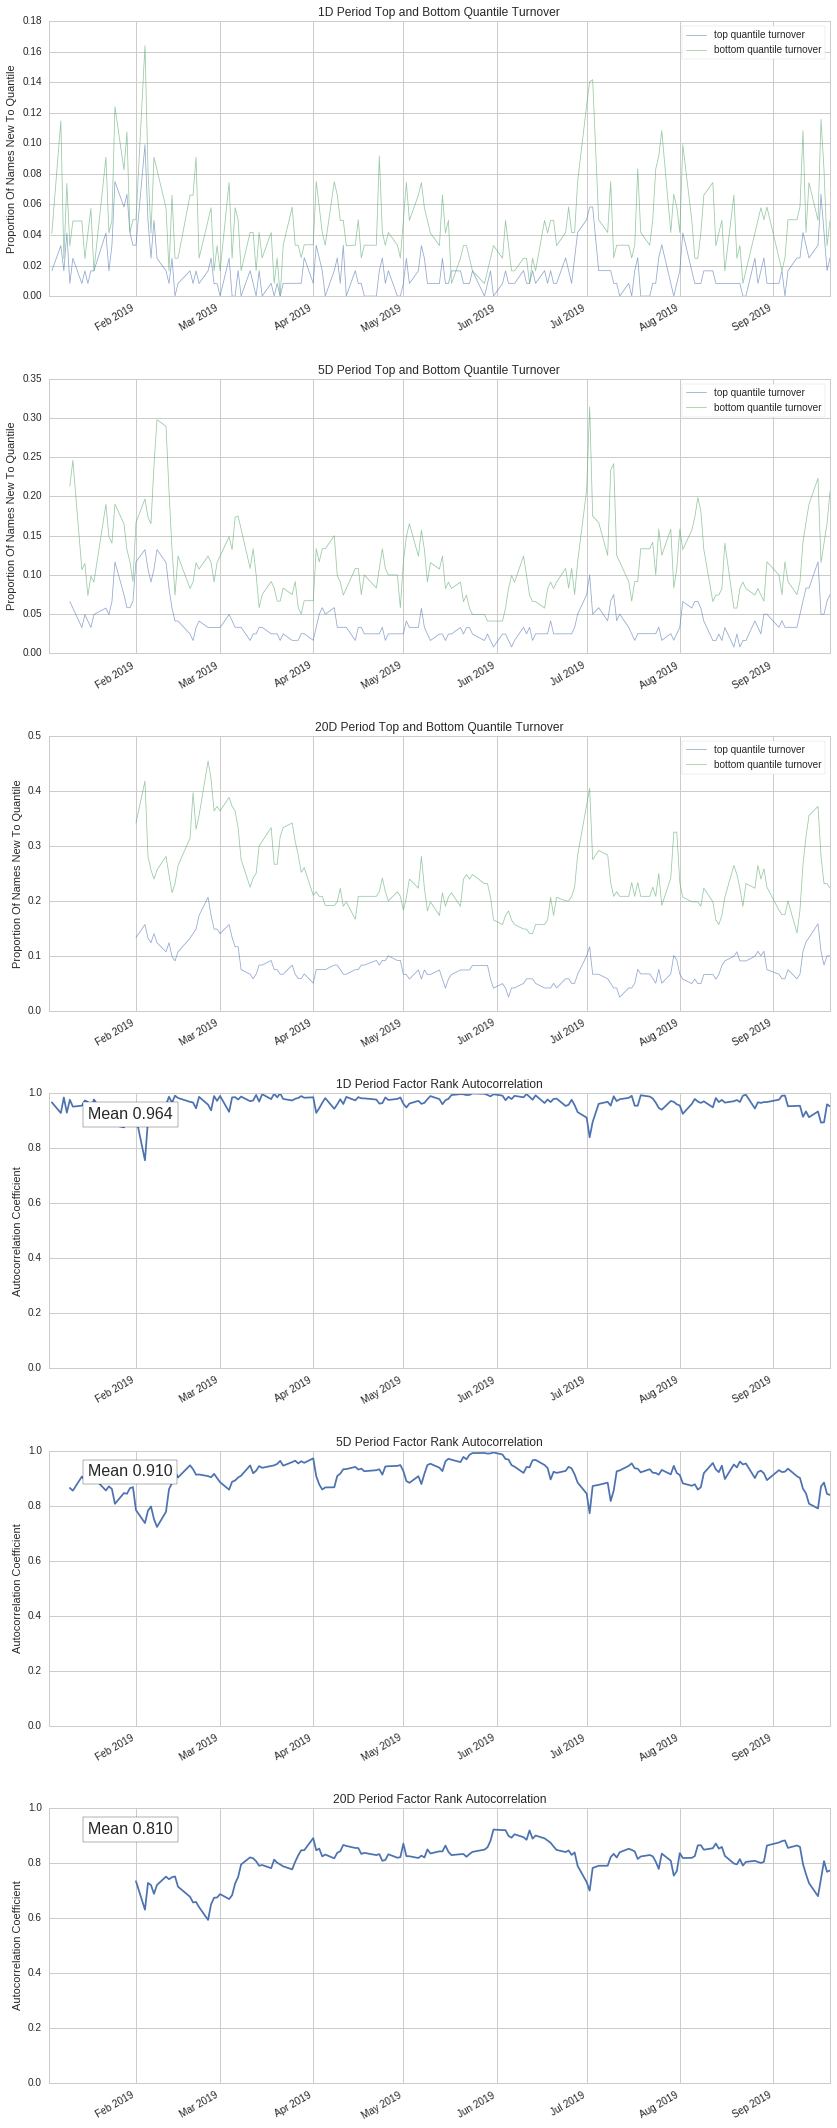

In [11]:
df['custom_xall'] = df['s_all']/(df['vol']*100) 
df = df.dropna()
df = df[df>-np.inf]

# Import prices function
from quantopian.research import prices

# Get list of unique assets from the pipeline output
asset_list = df.index.levels[1].unique()

# Query pricing data for all assets present during
# evaluation period
asset_prices = prices(
    asset_list,
    start='2019-01-02',
    end='2019-10-18'
)


# Import Alphalens
import alphalens as al

# Get asset forward returns and quantile classification
# based on sentiment scores
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=df['custom_xall'],
    prices=asset_prices,
    quantiles=3,
    periods=(1,5,20)
)

al.tears.create_full_tear_sheet(factor_data)
